In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# Cargar dataset
DATA_PATH = "../creditcard.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop("Class", axis=1)
y = df["Class"]

# Escalar Time y Amount
scaler = StandardScaler()
X[["Time", "Amount"]] = scaler.fit_transform(X[["Time", "Amount"]])

# Train-test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size: ", X_test.shape)



Train size: (199364, 30)
Test size:  (85443, 30)


In [4]:
def evaluate_model(name, model, X_test, y_test):
    """
    Imprime métricas clave para un modelo de clasificación en fraude.
    Devuelve un diccionario con métricas para comparar luego.
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    roc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"\n===== {name} =====")
    print(f"ROC-AUC: {roc:.6f}")
    print(f"PR-AUC:  {pr_auc:.6f}")
    print(classification_report(y_test, y_pred))

    report = classification_report(y_test, y_pred, output_dict=True)
    f1_fraud = report["1"]["f1-score"]
    recall_fraud = report["1"]["recall"]
    precision_fraud = report["1"]["precision"]

    return {
        "model": name,
        "roc_auc": roc,
        "pr_auc": pr_auc,
        "precision_fraud": precision_fraud,
        "recall_fraud": recall_fraud,
        "f1_fraud": f1_fraud,
    }


In [5]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500, n_jobs=-1)
log_reg.fit(X_train, y_train)

metrics_lr = evaluate_model("Logistic Regression (Baseline)", log_reg, X_test, y_test)



===== Logistic Regression (Baseline) =====
ROC-AUC: 0.955981
PR-AUC:  0.707110
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

metrics_rf = evaluate_model("Random Forest", rf, X_test, y_test)



===== Random Forest =====
ROC-AUC: 0.936469
PR-AUC:  0.827338
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.78      0.87       148

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [7]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm_linear = LinearSVC(class_weight="balanced", max_iter=5000)

svm_calibrated = CalibratedClassifierCV(svm_linear, cv=5)
svm_calibrated.fit(X_train, y_train)

metrics_svm = evaluate_model("LinearSVC Calibrated", svm_calibrated, X_test, y_test)



===== LinearSVC Calibrated =====
ROC-AUC: 0.968239
PR-AUC:  0.703115
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.55      0.67       148

    accuracy                           1.00     85443
   macro avg       0.93      0.78      0.84     85443
weighted avg       1.00      1.00      1.00     85443



In [8]:
results_df = pd.DataFrame([metrics_lr, metrics_rf, metrics_svm])
results_df


,model,roc_auc,pr_auc,precision_fraud,recall_fraud,f1_fraud
0,Logistic Regression (Baseline),0.9560,0.7071,0.8585,0.6149,0.7165
1,Random Forest,0.9365,0.8273,0.9667,0.7838,0.8657
2,LinearSVC Calibrated,0.9682,0.7031,0.8542,0.5541,0.6721


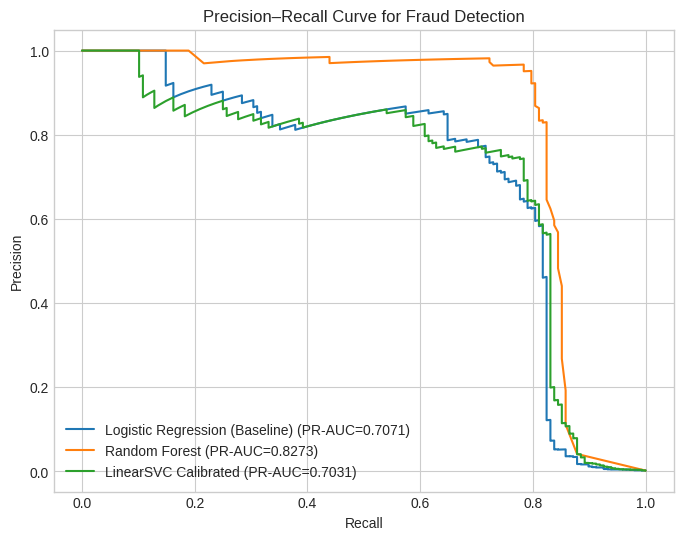

In [9]:
def plot_pr_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for model, name in zip(models, model_names):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.4f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve for Fraud Detection")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

models = [log_reg, rf, svm_calibrated]
names = [
    "Logistic Regression (Baseline)",
    "Random Forest",
    "LinearSVC Calibrated"
]

plot_pr_curve(models, names, X_test, y_test)
